In [26]:
import glob
from os import path

from astropy.io import fits
import numpy as np
from scipy import ndimage

import ppxf as ppxf_package
from ppxf.ppxf import ppxf
import ppxf.ppxf_util as util

import matplotlib.pyplot as plt

In [27]:
ppxf_dir = '/home/carlosmelo/Desktop/ppxf'
file = 'soma.fits'
hdu = fits.open(file)
gal_lin = hdu[1].data
h1 = hdu[1].header
var = hdu[2].data
h_var = hdu[2].header

In [28]:
lambRange1 = h1['CRVAL1'] + np.array([0.,h1['CDELT1']*(h1['NAXIS1']-1)])
FWHM_gal = 2.71
lambRange1

array([4755.17382812, 5500.17382812])

In [29]:
lamRange_var = h_var['CRVAL1'] + np.array([0.,h_var['CDELT1']*(h_var['NAXIS1']-1)])
lamRange_var

array([4755.17382812, 5500.17382812])

In [30]:
#z = 0.035 # Initial estimate of the galaxy redshift
#lambRange1 = lambRange1/(1+z) # Compute approximate restframe wavelength range
#FWHM_gal = FWHM_gal/(1+z)
#FWHM_gal

In [31]:
galaxy, logLam1, velscale = util.log_rebin(lambRange1, gal_lin)
variance, loglam_var, velscale_var = util.log_rebin(lamRange_var, var)
median_galaxy = np.median(galaxy)
galaxy = galaxy/np.median(galaxy)
noise = np.sqrt(variance)
noise = noise/median_galaxy
lam = np.exp(logLam1)


In [32]:
vazdekis = glob.glob(ppxf_dir + '/miles_models/Mun1.30*.fits') 
FWHM_tem = 2.51
velscale_ratio = 2
len(vazdekis)
h2 = fits.open(vazdekis[0])
ssp = hdu[0].data
h2 = hdu[0].header
ssp

In [33]:
hdu = fits.open(vazdekis[0])
ssp = hdu[0].data
h2 = hdu[0].header
lamRange2 = h2['CRVAL1'] + np.array([0., h2['CDELT1']*(h2['NAXIS1'] - 1)])
sspNew, logLam2, velscale_temp = util.log_rebin(lamRange2, ssp, velscale=velscale/velscale_ratio)
templates = np.empty((sspNew.size, len(vazdekis)))
lamRange2

array([3540.5, 7409.6])

In [34]:
FWHM_dif = np.sqrt(FWHM_gal**2 - FWHM_tem**2)
sigma = FWHM_dif/2.355/h2['CDELT1']
sigma

0.4820774625881504

In [35]:
for j, file in enumerate(vazdekis):
        hdu = fits.open(file)
        ssp = hdu[0].data
        ssp = ndimage.gaussian_filter1d(ssp, sigma)
        sspNew, logLam2, velscale_temp = util.log_rebin(lamRange2, ssp, velscale=velscale/velscale_ratio)
        templates[:, j] = sspNew/np.median(sspNew)
        

In [36]:
c = 299792.458
dv = (np.mean(logLam2[:velscale_ratio]) - logLam1[0])*c
len(templates)


6049

In [37]:
z = 0.035
goodPixels = util.determine_goodpixels(logLam1, lamRange2, z)
len(goodPixels)
len(logLam1)

597

In [38]:
vel = c*np.log(1 + z)
start = [vel, 200.] 

Best Fit:       Vel     sigma        h3        h4
 comp. 0:      9994       365    -0.036     0.061
chi2/DOF: 1.687
method = capfit; Jac calls: 6; Func calls: 32; Status: 2
Nonzero (>0.1%) Templates: 2 / 150


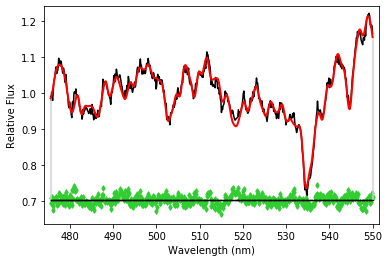

In [42]:
pp = ppxf(templates, galaxy, noise, velscale, start,
            lam = lam, plot=True, moments=4,
              degree=6,vsyst=dv,velscale_ratio=velscale_ratio)

array([ 9.99409390e+03,  3.64924473e+02, -3.61859009e-02,  6.11634688e-02])